# Positionable Camera

In [ ]:
import os
import numpy as np
import cupy as cp

from camera import CameraSettings
from camera import Camera
from world import world
from display_image import write_and_display

dn = os.path.join(os.path.dirname(os.getcwd()), 'kernels')
fnl = list()
fnl.append(os.path.join(dn, 'vec3.cuh'))
fnl.append(os.path.join(dn, 'util_rand.cuh'))
fnl.append(os.path.join(dn, 'interval.cuh'))
fnl.append(os.path.join(dn, 'ray.cuh'))
fnl.append(os.path.join(dn, 'hittable.cuh'))
fnl.append(os.path.join(dn, 'material.cuh'))
fnl.append(os.path.join(dn, 'hittable_list.cuh'))
fnl.append(os.path.join(dn, 'sphere.cuh'))
fnl.append(os.path.join(dn, 'world.cu'))
fnl.append(os.path.join(dn, 'render.cu'))

cuda_source = None
for fpfn in fnl:
    with open(fpfn, 'r') as f:
        cs = f.read()
    if cuda_source is None:
        cuda_source = cs
    else:
        cuda_source += cs

In [ ]:
settings = CameraSettings()
settings.aspect_ratio = 16.0 / 9.0
settings.image_width = int(400)
settings.samples_per_pixel = int(100)
settings.max_depth = int(50)

settings.vfov = int(20)
settings.lookfrom = (-2, 2, 1)
settings.lookat = (0, 0, -1)
settings.vup = (0, 1, 0)

settings.sz_block = 32, 32
camera = Camera(settings, cuda_source)
camera.setup_module()

In [ ]:
w = world(camera.module)
w.create_world()

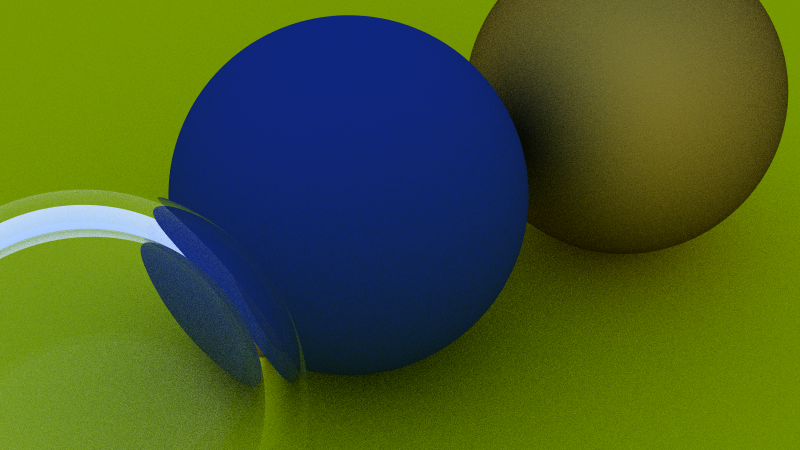

In [ ]:
img_gpu = camera.render(w)
img = img_gpu.get()
img8 = (img * np.float32(255.99)).astype(np.uint8)

write_and_display(img8)
w.destroy_world()